# Import libraries

In [2]:
# Imports
import sys
import os
sys.path.append(os.path.abspath("../"))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Custom Functions
from functions.validation_functions import *
from config import (
    SFINCS_WD_FILE, SFINCS_WL_FILE,
    CFM_WD_TIF, CFM_WL_TIF,
    CFM_A_WD_FINAL_TIF, CFM_A_WL_FINAL_TIF,
    ALIGNED_HWM_SHP, HWM_VS_SFINCS_SHP,
    HWM_VS_CFM_SHP, HWM_VS_CFM_A_SHP,
    LAND_CORE_TIF, CONFUSION_MATRIX_CFM_TIF,
    CONFUSION_MATRIX_CFM_A_TIF
)


## Confusion Matrix Generation against SFINCS

In [4]:
# Load SFINCS flood map
with rasterio.open(SFINCS_WD_FILE) as src:
    sfincs_flood = src.read(1).astype(np.float32)
    sfincs_profile = src.profile.copy()
    sfincs_nodata = src.nodata

# Load Coastal Flood Map (CFM)
with rasterio.open(CFM_WD_TIF.replace(".tif", "_over_1m.tif")) as src:
    cfm_flood = src.read(1).astype(np.float32)
    cfm_nodata = src.nodata

# Load Coastal Flood Map + Attenuation (CFM+A)
with rasterio.open(CFM_A_WD_FINAL_TIF.replace(".tif", "_over_1m.tif")) as src:
    cfm_a_flood = src.read(1).astype(np.float32)
    cfm_a_nodata = src.nodata

# Load inland mask
with rasterio.open(LAND_CORE_TIF) as src:
    inland_mask = src.read(1).astype(np.uint8)


In [5]:
# Replace NoData values with NaN
sfincs_flood = np.where(sfincs_flood == sfincs_nodata, np.nan, sfincs_flood)
cfm_flood= np.where(cfm_flood == cfm_nodata, np.nan, cfm_flood)
cfm_a_flood = np.where(cfm_a_flood == cfm_a_nodata, np.nan, cfm_a_flood)

# Apply inland mask
sfincs_flood = np.where(inland_mask == 1, sfincs_flood, np.nan)
cfm_flood = np.where(inland_mask == 1, cfm_flood, np.nan)
cfm_a_flood = np.where(inland_mask == 1, cfm_a_flood, np.nan)


In [6]:
# Binary masks
sfincs_binary = np.where(~np.isnan(sfincs_flood), 1, 0)
cfm_binary = np.where(~np.isnan(cfm_flood), 1, 0)
cfm_a_binary = np.where(~np.isnan(cfm_a_flood), 1, 0)


In [7]:
print(f"Flooded Cells Count:")
print(f"SFINCS flooded cells: {np.sum(sfincs_binary == 1):,}")
print(f"Coastal Flood Map (CFM) flooded cells: {np.sum(cfm_binary == 1):,}")
print(f"Coastal Flood Map + Attenuation (CFM+A) flooded cells: {np.sum(cfm_a_binary == 1):,}")


Flooded Cells Count:
SFINCS flooded cells: 72,108,511
Coastal Flood Map (CFM) flooded cells: 74,620,514
Coastal Flood Map + Attenuation (CFM+A) flooded cells: 68,066,763


In [8]:
# Confusion matrices
confusion_cfm = compute_confusion_matrix(sfincs_binary, cfm_binary, inland_mask)
confusion_cfm_a = compute_confusion_matrix(sfincs_binary, cfm_a_binary, inland_mask)

# Metrics
metrics_cfm = compute_extent_metrics(confusion_cfm)
metrics_cfm_a = compute_extent_metrics(confusion_cfm_a)

# True/False Positives/Negatives
TP_cfm, TN_cfm, FP_cfm, FN_cfm = np.sum(confusion_cfm == 3), np.sum(confusion_cfm == 0), np.sum(confusion_cfm == 1), np.sum(confusion_cfm == 2)
TP_cfm_a, TN_cfm_a, FP_cfm_a, FN_cfm_a = np.sum(confusion_cfm_a == 3), np.sum(confusion_cfm_a == 0), np.sum(confusion_cfm_a == 1), np.sum(confusion_cfm_a == 2)


In [13]:
print("\nCoastal Flood Map (CFM) Validation Metrics:")
for k, v in metrics_cfm.items():
    print(f"{k}: {v:.4f}")
print(f"TP: {TP_cfm:,} | TN: {TN_cfm:,} | FP: {FP_cfm:,} | FN: {FN_cfm:,}")

print("\nCoastal Flood Map + Attenuation (CFM+A) Validation Metrics:")
for k, v in metrics_cfm_a.items():
    print(f"{k}: {v:.4f}")
print(f"TP: {TP_cfm_a:,} | TN: {TN_cfm_a:,} | FP: {FP_cfm_a:,} | FN: {FN_cfm_a:,}")



Coastal Flood Map (CFM) Validation Metrics:
CSI: 0.7754
Precision: 0.8588
Recall: 0.8887
Specificity: 0.9721
F1_Score: 0.8735
FDR: 0.1412
Proportion_Correct: 0.9587
Bias_Ratio: 1.0348
TP: 64,084,958 | TN: 366,828,760 | FP: 10,535,556 | FN: 8,023,553

Coastal Flood Map + Attenuation (CFM+A) Validation Metrics:
CSI: 0.7585
Precision: 0.8883
Recall: 0.8385
Specificity: 0.9799
F1_Score: 0.8627
FDR: 0.1117
Proportion_Correct: 0.9572
Bias_Ratio: 0.9439
TP: 60,462,882 | TN: 369,760,435 | FP: 7,603,881 | FN: 11,645,629


In [15]:
# ---------------------------------------
# Save Confusion Rasters
# ---------------------------------------

sfincs_profile.update(dtype=rasterio.uint8, count=1, nodata=255)

with rasterio.open(CONFUSION_MATRIX_CFM_TIF, 'w', **sfincs_profile) as dst:
    dst.write(confusion_cfm, 1)

with rasterio.open(CONFUSION_MATRIX_CFM_A_TIF, 'w', **sfincs_profile) as dst:
    dst.write(confusion_cfm_a, 1)

print("\nConfusion matrix rasters exported for Coastal Flood Map (CFM) and Coastal Flood Map + Attenuation (CFM+A).")


Confusion matrix rasters exported for Coastal Flood Map (CFM) and Coastal Flood Map + Attenuation (CFM+A).


## Compare Water Level Results against High Water Marks

In [17]:
# Compare HWMs
sfincs_results = compare_hwm_with_model(SFINCS_WL_FILE, ALIGNED_HWM_SHP, HWM_VS_SFINCS_SHP)
cfm_results = compare_hwm_with_model(CFM_WL_TIF, ALIGNED_HWM_SHP, HWM_VS_CFM_SHP)
cfm_a_results = compare_hwm_with_model(CFM_A_WL_FINAL_TIF, ALIGNED_HWM_SHP, HWM_VS_CFM_A_SHP)


In [18]:
print("\n✅ HWM Comparison - SFINCS:")
for k, v in sfincs_results.items():
    print(f"{k}: {v:.4f}")

print("\n✅ HWM Comparison - CFM:")
for k, v in cfm_results.items():
    print(f"{k}: {v:.4f}")

print("\n✅ HWM Comparison - CFM+A:")
for k, v in cfm_a_results.items():
    print(f"{k}: {v:.4f}")



✅ HWM Comparison - SFINCS:
Num Points: 48.0000
RMSE: 0.6266
MAE: 0.4827
Bias: -0.1367
Scatter Index: 0.1718

✅ HWM Comparison - CFM:
Num Points: 57.0000
RMSE: 0.5203
MAE: 0.3710
Bias: 0.1785
Scatter Index: 0.1457

✅ HWM Comparison - CFM+A:
Num Points: 57.0000
RMSE: 0.4782
MAE: 0.3358
Bias: 0.0936
Scatter Index: 0.1339


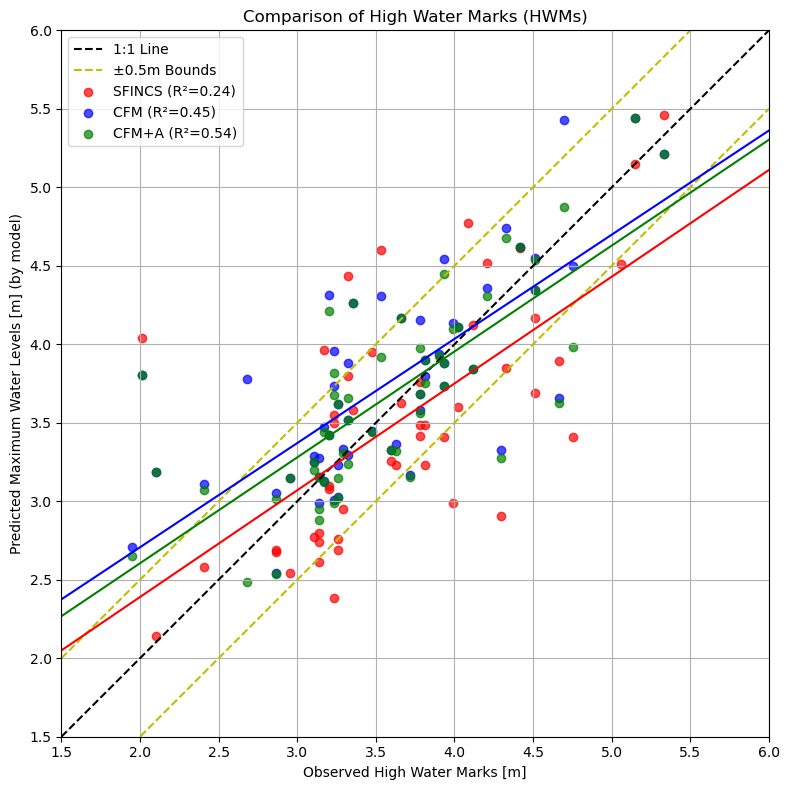

In [20]:
# Load HWM comparison shapefiles
sfincs_gdf = gpd.read_file(HWM_VS_SFINCS_SHP)
cfm_gdf = gpd.read_file(HWM_VS_CFM_SHP)
cfm_a_gdf = gpd.read_file(HWM_VS_CFM_A_SHP)

# Extract and clean HWM comparison data
def clean_observed_predicted(gdf):
    observed = gdf["hwm"].values
    predicted = gdf["wse"].values
    valid = ~np.isnan(observed) & ~np.isnan(predicted)
    return observed[valid], predicted[valid]

observed_sfincs, predicted_sfincs = clean_observed_predicted(sfincs_gdf)
observed_cfm, predicted_cfm = clean_observed_predicted(cfm_gdf)
observed_cfm_a, predicted_cfm_a = clean_observed_predicted(cfm_a_gdf)

# Plot comparison
plot_hwm_comparison(
    observed_list=[observed_sfincs, observed_cfm, observed_cfm_a],
    predicted_list=[predicted_sfincs, predicted_cfm, predicted_cfm_a],
    labels=["SFINCS", "CFM", "CFM+A"],
    colors=["red", "blue", "green"]
)
